# Import data

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import datetime
from fitter import Fitter
import seaborn as sns
DOG = pd.read_csv(r"D:\BaiduNetdiskDownload\IC\Term 1\QRM\CW 1\QRM-2021-cw1-data-b.csv",index_col = 0)
DOG.index = [datetime.datetime.strptime(i,"%Y-%m-%d") for i in DOG.index]
DOG.index.name = 'Date'
DOG['Log_return'] = np.log(DOG.DOG/DOG.DOG.shift(1))
DOG['Loss'] = -DOG.Log_return

Loss = DOG.iloc[1:,2]
length = len(Loss)
win_width = 500

DOG.tail()

,DOG,Log_return,Loss
Date,,,
2019-11-04,51.48,-0.004458,0.004458
2019-11-05,51.40,-0.001555,0.001555
2019-11-06,51.42,0.000389,-0.000389
2019-11-07,50.99,-0.008398,0.008398
2019-11-08,51.03,0.000784,-0.000784


# 1) Historical Simulation

In [3]:
VaR_95_HS = list(Loss.rolling(window=500, center = False).quantile(.95)[499:-1])
VaR_99_HS = list(Loss.rolling(window=500, center = False).quantile(.99)[499:-1])
ES_95_HS = [sum(Loss[i:i+win_width].sort_values().iloc[-25:])/25 for i in range(length-win_width)]
ES_99_HS = [sum(Loss[i:i+win_width].sort_values().iloc[-5:])/5 for i in range(length-win_width)]
Risk_HS = pd.DataFrame({'Loss':Loss[500:],'VaR_95':VaR_95_HS,'VaR_99':VaR_99_HS,'ES_95':ES_95_HS,'ES_99':ES_99_HS})
Risk_HS.index = DOG.index[501:]
Risk_HS.index.name = 'Date'
Risk_HS.head()

,Loss,VaR_95,VaR_99,ES_95,ES_99
Date,,,,,
2011-11-03,0.017862,0.017069,0.02924,0.025084,0.035802
2011-11-04,-0.004944,0.017115,0.02924,0.025114,0.035802
2011-11-07,0.007199,0.017115,0.02924,0.025114,0.035802
2011-11-08,0.009073,0.017115,0.02924,0.025114,0.035802
2011-11-09,-0.030419,0.017115,0.02924,0.025114,0.035802


<AxesSubplot:xlabel='Date'>

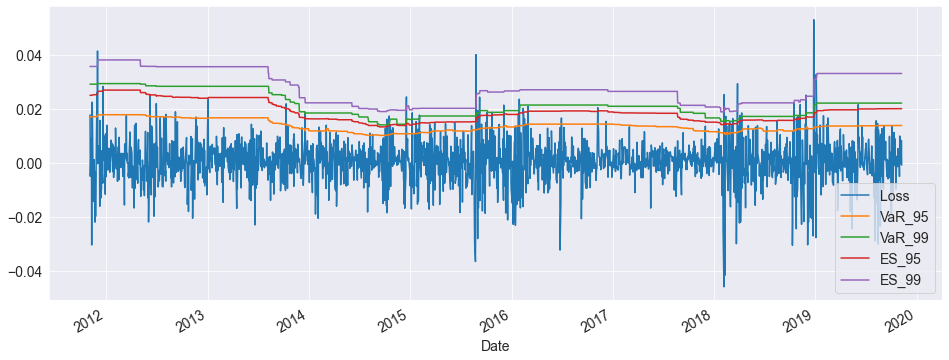

In [36]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

Risk_HS.plot()

# 2) Filtered historical simulation with EWMA

In [37]:
("Mean of Loss is",np.mean(Loss))

('Mean of Loss is', 0.0005715519892195428)

## Calculate $\sigma_{t}$

In [38]:
alpha = 0.06
sigma_2_EWMA = np.zeros(2518)
sigma_2_EWMA[0] = (np.var(Loss))

def EWMA(sigma_2_t,Xt):
    sigma_2_T = 0.06*Xt**2 + 0.94*sigma_2_t
    return sigma_2_T


for i in range(2517):
    sigma_2_EWMA[i+1] = EWMA(sigma_2_EWMA[i],Loss[i])

sigma_EWMA = np.sqrt(sigma_2_EWMA[1:])

{'norm': (0.07788977798159806, 0.954288304530431),
 't': (11.668676745819187, 0.09658487305331365, 0.8706235147530156)}

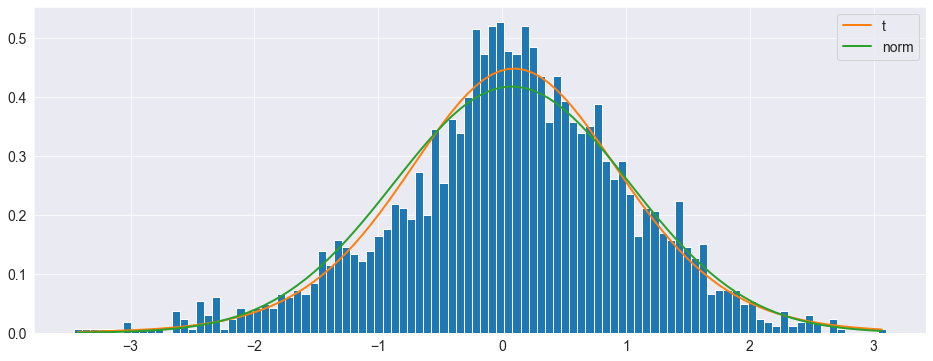

In [39]:
Z_EWMA = pd.Series(np.array(Loss)/sigma_EWMA)
Z_EWMA.columns = ['Z']
Z_EWMA.index = DOG.index[1:]

f = Fitter(Z_EWMA,distributions=['norm','t'])
f.fit()
f.summary()
f.fitted_param

In [40]:
Z_VaR_95 = list(Z_EWMA.rolling(window=500, center = False).quantile(.95)[499:-1])
Z_VaR_99 = list(Z_EWMA.rolling(window=500, center = False).quantile(.99)[499:-1])
Z_ES_95 = [sum(Z_EWMA[i:i+win_width].sort_values()[-25:])/25 for i in range(length-win_width)]
Z_ES_99 = [sum(Z_EWMA[i:i+win_width].sort_values()[-5:])/5 for i in range(length-win_width)]

VaR_95_EWMA = Z_VaR_95*sigma_EWMA[500:]
VaR_99_EWMA = Z_VaR_99*sigma_EWMA[500:]
ES_95_EWMA = Z_ES_95*sigma_EWMA[500:]
ES_99_EWMA = Z_ES_99*sigma_EWMA[500:]

Risk_EWMA = pd.DataFrame({'Loss':Loss[500:],'VaR_95':VaR_95_EWMA,'VaR_99':VaR_99_EWMA,'ES_95':ES_95_EWMA,'ES_99':ES_99_EWMA})
Risk_EWMA.head()


,Loss,VaR_95,VaR_99,ES_95,ES_99
Date,,,,,
2011-11-03,0.017862,0.027557,0.035948,0.033348,0.041454
2011-11-04,-0.004944,0.026785,0.034942,0.032415,0.040293
2011-11-07,0.007199,0.026118,0.034071,0.031607,0.039290
2011-11-08,0.009073,0.025564,0.033349,0.030937,0.038456
2011-11-09,-0.030419,0.027433,0.035786,0.033198,0.041267


<AxesSubplot:xlabel='Date'>

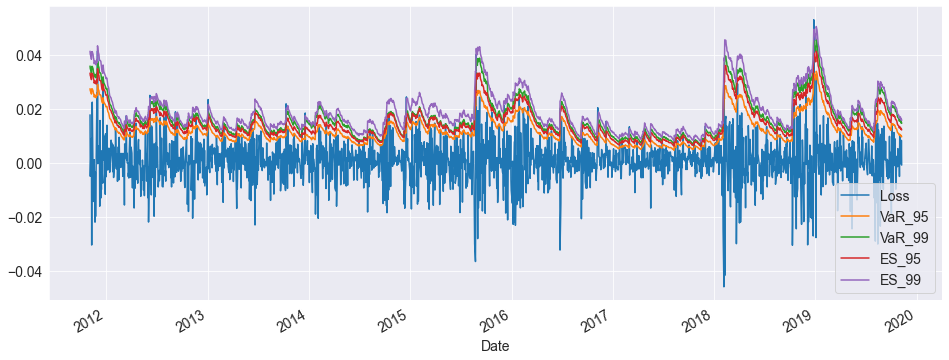

In [41]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

Risk_EWMA.plot()

# 3) Filtered historical simulation with GARCH

In [42]:
from arch import arch_model
from arch.__future__ import reindexing

In [43]:
sigma_2_GARCH = []
mu_GARCH = []
Z_VaR_95_G = []
Z_VaR_99_G = []
Z_ES_95_G = []
Z_ES_99_G = []

for i in range(length-500):
    garch = arch_model(Loss[i:i+win_width],rescale=False,mean='Constant', lags=0, vol='Garch', p=1, o=0, q=1, power=2.0, dist='Normal')
    model = garch.fit(disp = 'off')
    sigma_2_GARCH.append(model.forecast(horizon=1,simulations=1).variance['h.1'][0])
    mu_GARCH.append(model.params[0])
    
    resid = model.std_resid
    resid.columns = ['Z']
    
    Z_VaR_95_G.append(resid.quantile(.95))
    Z_VaR_99_G.append(resid.quantile(.99))
    Z_ES_95_G.append(sum(resid.sort_values()[-25:])/25)
    Z_ES_99_G.append(sum(resid.sort_values()[-5:])/5)
    #print(Z_VaR_95_G,Z_ES_95_G)
    
sigma_GARCH = np.sqrt(sigma_2_GARCH)


In [46]:
VaR_95_GARCH = Z_VaR_95_G*sigma_GARCH + mu_GARCH
VaR_99_GARCH = Z_VaR_99_G*sigma_GARCH + mu_GARCH
ES_95_GARCH = Z_ES_95_G*sigma_GARCH + mu_GARCH
ES_99_GARCH = Z_ES_99_G*sigma_GARCH + mu_GARCH

Risk_GARCH = pd.DataFrame({'Loss':Loss[500:],'VaR_95':VaR_95_GARCH,'VaR_99':VaR_99_GARCH,'ES_95':ES_95_GARCH,'ES_99':ES_99_GARCH,'mu':mu_GARCH})
Risk_GARCH.head()

,Loss,VaR_95,VaR_99,ES_95,ES_99,mu
Date,,,,,,
2011-11-03,0.017862,0.025911,0.036676,0.033540,0.044717,0.000999
2011-11-04,-0.004944,0.025449,0.036458,0.033311,0.044463,0.000999
2011-11-07,0.007199,0.024217,0.034679,0.031649,0.042280,0.000992
2011-11-08,0.009073,0.023254,0.032991,0.030192,0.040230,0.001023
2011-11-09,-0.030419,0.022293,0.031693,0.028997,0.038632,0.001012


<AxesSubplot:xlabel='Date'>

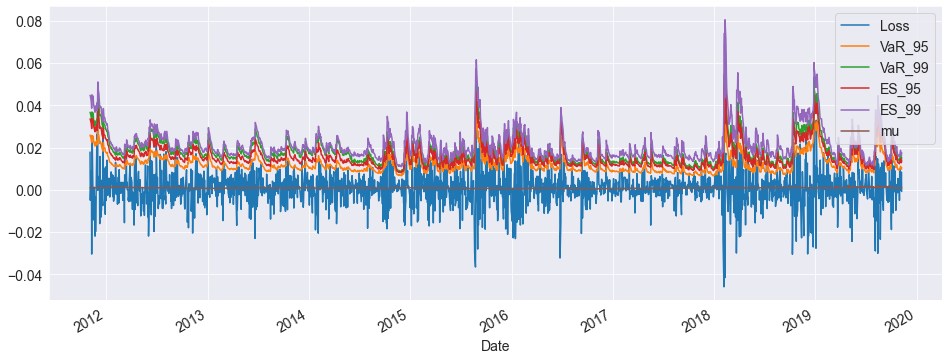

In [47]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

Risk_GARCH.plot()

In [48]:
from scipy.stats import chi2,norm 
def Unconditional_coverage_test(alpha,Loss,VaR):
    I = np.array([Loss>VaR])
    pi_hat = np.mean(I)
    LR_uc = -2*np.log(np.prod(alpha**(1-I)*(1-alpha)**I)/np.prod((1-pi_hat)**(1-I)*pi_hat**I))
    p = 1 - chi2.cdf(LR_uc,1)
    return p


for i,k in zip([Risk_HS,Risk_EWMA,Risk_GARCH],['HS','EWMA','GARCH']):
    print('Unconditional coverage test of',k,':')
    for j in [95,99]:
        print('VaR',j,':',Unconditional_coverage_test(j/100,i.Loss,i['VaR_'+str(j)]))

Unconditional coverage test of HS :
VaR 95 : 0.8496569502929882
VaR 99 : 0.14615050075102187
Unconditional coverage test of EWMA :
VaR 95 : 0.6922942557694061
VaR 99 : 0.14615050075102132
Unconditional coverage test of GARCH :
VaR 95 : 0.7699166235636291
VaR 99 : 0.5356220013678803


In [49]:
def Joint_test(alpha,Loss,VaR):
    I = np.array(Loss>VaR)
    pi_hat = np.mean(I)
    LR_uc = np.prod(alpha**(1-I)*(1-alpha)**I)/np.prod((1-pi_hat)**(1-I)*pi_hat**I)
    
    I_10 = sum(I[1:]<I[:-1])
    I_00 = sum(I[:-1]==0) - I_10
    I_01 = sum(I[1:]>I[:-1])
    I_11 = sum(I[:-1]==1) - I_01
    
    pi_11 = I_11/(I_10+I_11)
    pi_01 = I_01/(I_00+I_01)
    
    L = (1-pi_01)**I_00*pi_01**I_01*(1-pi_11)**I_10*pi_11**I_11
    L_0 = (1-pi_hat)**I_00*pi_hat**I_01*(1-pi_hat)**I_10*pi_hat**I_11
    LR_ind = -2*np.log(L_0/L)
    #print(LR_ind,LR_uc)
    p = 1 - chi2.cdf(LR_uc+LR_ind,2)
    
    return p

for i,k in zip([Risk_HS,Risk_EWMA,Risk_GARCH],['HS','EWMA','GARCH']):
    print('Joint test of',k,':')
    for j in [95,99]:
        print('VaR',j,':',Joint_test(j/100,i.Loss,i['VaR_'+str(j)]))

Joint test of HS :
VaR 95 : 0.13028197504032468
VaR 99 : 0.01568365728093779
Joint test of EWMA :
VaR 95 : 0.5960570994688665
VaR 99 : 0.5665112107016333
Joint test of GARCH :
VaR 95 : 0.20385210025123301
VaR 99 : 0.5075550455803877


In [50]:
def Backtesting_ES(alpha,Loss,VaR,ES):
    I = np.array(Loss>VaR)
    #print(I)
    kesi = np.array(Loss-ES)
    #print(np.square(kesi))
    Z = sum(kesi*I)/np.sqrt(sum(np.square(kesi)*I))
    p = 1-norm.cdf(Z)
    return p

for i,k in zip([Risk_HS,Risk_EWMA,Risk_GARCH],['HS','EWMA','GARCH']):
    print('ES_Backtesting of',k,':')
    for j in [95,99]:
        print('ES',j,':',Backtesting_ES(j/100,i.Loss,i['VaR_'+str(j)],i['ES_'+str(j)]))

ES_Backtesting of HS :
ES 95 : 0.1610343428308154
ES 99 : 0.3076555895670178
ES_Backtesting of EWMA :
ES 95 : 0.33529305715674196
ES 99 : 0.8210224135649926
ES_Backtesting of GARCH :
ES 95 : 0.4580528395666137
ES 99 : 0.5364182140717284
